<a href="https://www.kaggle.com/code/ameau01/histopathologeic-cancer-detection?scriptVersionId=248032839" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# CSCA-5642: Kaggle Cancerous Cell Detection Project #
#### Develop an algorithm that identifies metastatic cancer in small image patches from digital pathology scans. ####
    
* Author: Alexander Meau  
* Email: alme9155@colorado.edu  
* GitHub: [https://github.com/alme9155/csca-5642-week3/tree/main](https://github.com/alme9155/csca-5642-week3/tree/main)  


## I. Brief description of the problem and data ##

This project aims to tackle Kaggle's Cancer Detection challenge to identify cancerous cell images from non-cancerous using Convolutional Neural Network (CNN). The challenge is to create an algorithm to identify metastatic cancer in small image patches taken from larget digital pathlogy scans. The data of this Kaggle competition is a slightly modified version of the PatchCamelyon (PCam) benchmark dataset. 
### Dataset: ####
* The training dataset contains about 220,025 image patches already labeled 1 as cancerous, 0 as non-cancerous in "train_labels.csv".
* A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue.
* Tumor tissue in the outer region of the patch does not influence the label. 

### Data Size and Dimension ####
* Training dataset: 220,025 tiff images
* Test dataset: 57,458 tiff images (~26% of training size)
* Each image patch is 96x96 pixel of RGB color images in tiff formats.
* Label CSV contains 2 columns: id, label (1 as cancerous, 0 as non-cancerous)

### Competition Rules ###
* Expected submission CSV files in the same format as "train_labels.csv" with two columns "id, label". (id: unique id from test set, label: 0, or 1)

In [8]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
tif_files = []

for dirname, _, filenames in os.walk('/kaggle/input'):
    print(f"\nos path: [{dirname}]")
    tif_file_count =0
    for filename in filenames:
        if filename.endswith('.tif'):
            tif_file_count +=1
            if tif_file_count < 3:
                print(os.path.join(dirname, filename))
            elif tif_file_count == 3:
                print("...")
        else:
            print(os.path.join(dirname, filename))  
    if tif_file_count > 0:
        print(f"\nTotal number of .tif files in {dirname}: {tif_file_count}")
        tif_file_count =0

        
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


os path: [/kaggle/input]

os path: [/kaggle/input/histopathologic-cancer-detection]
/kaggle/input/histopathologic-cancer-detection/sample_submission.csv
/kaggle/input/histopathologic-cancer-detection/train_labels.csv

os path: [/kaggle/input/histopathologic-cancer-detection/test]
/kaggle/input/histopathologic-cancer-detection/test/a7ea26360815d8492433b14cd8318607bcf99d9e.tif
/kaggle/input/histopathologic-cancer-detection/test/59d21133c845dff1ebc7a0c7cf40c145ea9e9664.tif
...

Total number of .tif files in /kaggle/input/histopathologic-cancer-detection/test: 57458

os path: [/kaggle/input/histopathologic-cancer-detection/train]
/kaggle/input/histopathologic-cancer-detection/train/d43c081bafa286f9c1f7e921883f26ceafebc912.tif
/kaggle/input/histopathologic-cancer-detection/train/092d0eedebce504847715ee046b6ad74b57599b4.tif
...

Total number of .tif files in /kaggle/input/histopathologic-cancer-detection/train: 220025


## II. Exploratory Data Analysis (EDA) ##
File: "train_label.csv"
- Inspect file columns, duplciates and null labels.
- Pre-process data frame to add 'train_filepath' for ease access to locate the files
- Pre-process data to convert 'label' as string
- Drop any rows in the dataset where corresponding .tif file path is missing.

In [20]:
import pandas as pd
import os 

train_labels = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')
print("shape:",train_labels.shape)
print("-- Label head ---")
print("################")
print(train_labels.head())
print("-----------------")
print("Missing values: ")
print("################")
print(train_labels.isnull().sum())
print("-----------------")
print(f"Sum of duplicated labels: {train_labels.duplicated().sum()}.")

shape: (220025, 2)
-- Label head ---
################
                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0
-----------------
Missing values: 
################
id       0
label    0
dtype: int64
-----------------
Sum of duplicated labels: 0.


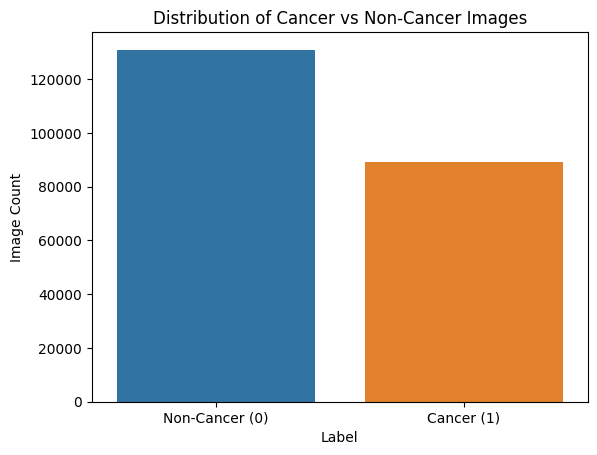

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='label', data=train_labels)
plt.xticks([0, 1], ['Non-Cancer (0)', 'Cancer (1)'])
plt.title("Distribution of Cancer vs Non-Cancer Images")
plt.ylabel("Image Count")
plt.xlabel("Label")
plt.show()

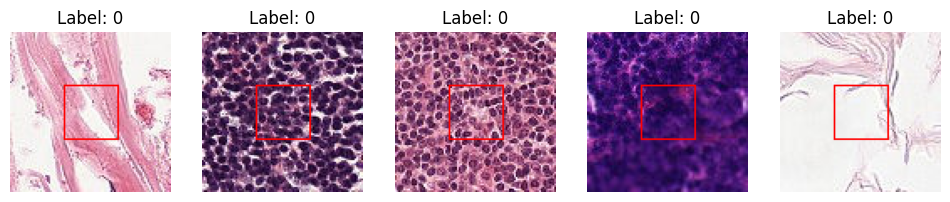

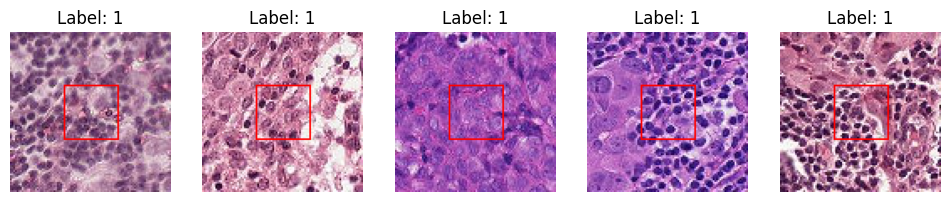

image size: (96, 96)
image mode: RGB


In [12]:
### show sample image files
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path

# add 'train_filepath' to dataframe
train_dir = Path("/kaggle/input/histopathologic-cancer-detection/train")
train_labels = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')
train_labels['train_filepath'] = train_labels['id'].apply(lambda x: str(train_dir / f'{x}.tif'))
# # convert 'label' field to string.
# train_labels['label'] = train_labels['label'].astype(str)

# show sample file
def show_samples(label, df=train_labels, num_images=5):
    subset = df[df['label'] == label].sample(num_images, random_state=42)
    plt.figure(figsize=(12, 4))
    for i, row in enumerate(subset.itertuples()):
        img = cv2.imread(row.train_filepath)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        center = (32, 32, 64, 64)  
        cv2.rectangle(img, (center[0], center[1]), (center[2], center[3]), (255, 0, 0), 1)
        plt.subplot(1, num_images, i+1)
        plt.imshow(img)
        plt.title(f'Label: {row.label}')
        plt.axis('off')
    plt.show()


show_samples(0)  # Non-cancerous
show_samples(1)  # Cancerous

# check image size and channel
img_path = f"/kaggle/input/histopathologic-cancer-detection/train/{train_labels['id'].iloc[0]}.tif"
img = Image.open(img_path)
print(f"image size: {img.size}") 
print(f"image mode: {img.mode}") 

In [13]:
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
import tensorflow_io as tfio
print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.18.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Pre-process the data ###

- Preprocess and split the data 80/20 into training and validation dataset
- Prepare load_image method to be used
- Prepare tensor pipeline to load image, label pair in mini-batch of 64

In [14]:
from sklearn.model_selection import train_test_split
import cv2


# Split the DataFrame into training and validation sets
train_df, val_df = train_test_split(
    train_labels,
    test_size=0.2,
    stratify=train_labels['label'],
    random_state=42
)

def load_image(path, label):
    def _load_image_py(path_tensor):
        path_str = path_tensor.numpy()
        if isinstance(path_str, bytes):
            path_str = path_str.decode("utf-8")
        img = cv2.imread(path_str)
        if img is None:
            raise ValueError(f"Failed to load image at path: {path_str}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        return img.astype(np.uint8)

    image = tf.py_function(func=_load_image_py, inp=[path], Tout=tf.uint8)
    image.set_shape([96, 96, 3])
    image = tf.cast(image, tf.float32) / 255.0
    label = tf.cast(label, tf.int32)  
    return image, label

# Create training and validation datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_df['train_filepath'], train_df['label']))
train_dataset = train_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(1000).batch(64).prefetch(tf.data.AUTOTUNE)

validation_dataset = tf.data.Dataset.from_tensor_slices((val_df['train_filepath'], val_df['label']))
validation_dataset = validation_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.batch(64).prefetch(tf.data.AUTOTUNE)

print("Data Pre-processing complete..")

Data Pre-processing complete..


## III. Model Architecture ##

### Model Description ###

- This model implements traditional CNN model with three layers architecture.
- Model begins with 32 filters, and then this hyperparameter value doubled of each subsequent layer: 32, 64, 128 
- Since each image size is 96 x 96 pixel of RGB channel, input shape = (96,96, 3)
- To avoid overfitting, each convolution block is matched with pooling layer and batch-normalization.
- First layer use 5x5 kernel to learn major feature and then 3x3 kernel following inspiration of VGG-16. 

#### Reference ###
- Ref: https://www.geeksforgeeks.org/computer-vision/vgg-16-cnn-model
- Ref: https://openaccess.thecvf.com/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf

<img src="https://developers.google.com/static/machine-learning/practica/image-classification/images/cnn_architecture.svg" width="600">

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.metrics import AUC

#input shape = 96x 96x 3 (width x height x RGB)
cnn_model = Sequential([
    # First CNN block 
    Conv2D(32, kernel_size=5, strides=1, padding='same', input_shape=(96, 96, 3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=2, strides=2),  
    
    # Second CNN block
    Conv2D(64, kernel_size=3, strides=1, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=2, strides=2), 
    
    # Third CNN block
    Conv2D(128, kernel_size=3, strides=1, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=2, strides=2), 
    
    # Output layer
    Flatten(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid') 
])

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', AUC(name='auroc')])
cnn_model.summary()
history = cnn_model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=10
)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 96, 96, 32)          │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 96, 96, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 96, 96, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 48, 48, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 48, 48, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 48, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 24, 24, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       4,718,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,814,785 (18.37 MB)

 Trainable params: 4,814,337 (18.37 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/10


I0000 00:00:1751218665.838416      98 service.cc:148] XLA service 0x7ecd4c058b70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751218665.839572      98 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1751218666.475728      98 cuda_dnn.cc:529] Loaded cuDNN version 90300


   1/2751 ━━━━━━━━━━━━━━━━━━━━ 10:19:04 14s/step - accuracy: 0.5469 - auroc: 0.6212 - loss: 1.2535

I0000 00:00:1751218671.428775      98 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2751/2751 ━━━━━━━━━━━━━━━━━━━━ 879s 315ms/step - accuracy: 0.6206 - auroc: 0.6514 - loss: 0.9767 - val_accuracy: 0.6271 - val_auroc: 0.6804 - val_loss: 0.7235
Epoch 2/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 307s 111ms/step - accuracy: 0.7097 - auroc: 0.7602 - loss: 0.5273 - val_accuracy: 0.6683 - val_auroc: 0.5894 - val_loss: 0.7638
Epoch 3/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 358s 129ms/step - accuracy: 0.7212 - auroc: 0.7711 - loss: 0.5128 - val_accuracy: 0.6811 - val_auroc: 0.6092 - val_loss: 0.9671
Epoch 4/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 348s 126ms/step - accuracy: 0.7289 - auroc: 0.7781 - loss: 0.5023 - val_accuracy: 0.8561 - val_auroc: 0.9013 - val_loss: 0.4439
Epoch 5/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 351s 127ms/step - accuracy: 0.7606 - auroc: 0.8173 - loss: 0.4735 - val_accuracy: 0.7665 - val_auroc: 0.8099 - val_loss: 0.9663
Epoch 6/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 346s 125ms/step - accuracy: 0.8477 - auroc: 0.8937 - loss: 0.3819 - val_accuracy: 0.8140 - val_auroc: 0.8768 - val_loss


Training Metrics:
---------------------------
Loss: 0.2848
Accuracy: 0.9003
Auroc: 0.9450

Validation Metrics:
---------------------------
Validation loss: 0.7119
Validation accuracy: 0.8192
Validation auroc: 0.8639


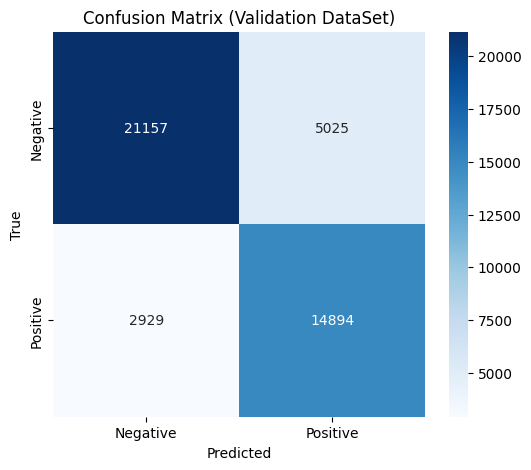


Confusion Matrix Metrics:
True Negatives (TN): 21157
False Positives (FP): 5025
False Negatives (FN): 2929
True Positives (TP): 14894


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

print("\nTraining Metrics:")
print("---------------------------")
for metric in ['loss', 'accuracy', 'auroc']:
    print(f"{metric.capitalize()}: {history.history[metric][-1]:.4f}")

print("\nValidation Metrics:")
print("---------------------------")
for metric in ['val_loss', 'val_accuracy', 'val_auroc']:
    print(f"{metric.replace('val_', 'Validation ').capitalize()}: {history.history[metric][-1]:.4f}")



# show confusion matrix
y_true = []
y_pred = []
for images, labels in validation_dataset:
    preds = cnn_model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend((preds > 0.5).astype(int).flatten())
y_true = np.array(y_true)
y_pred = np.array(y_pred)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'], 
            yticklabels=['Negative', 'Positive'])

plt.title('Confusion Matrix (Validation DataSet)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print("\nConfusion Matrix Metrics:")
print(f"True Negatives (TN): {cm[0,0]}")
print(f"False Positives (FP): {cm[0,1]}")
print(f"False Negatives (FN): {cm[1,0]}")
print(f"True Positives (TP): {cm[1,1]}")

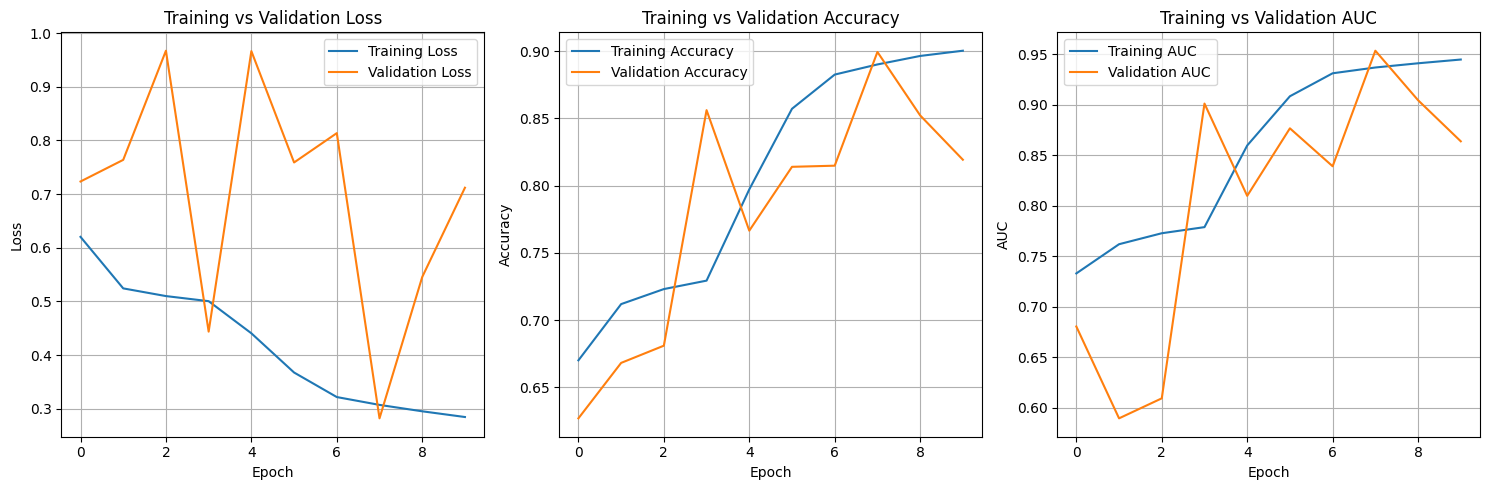

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix


# Training loss vs Validation Loss
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Training Accuracy vs Validation Accuracy
plt.subplot(1, 3, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# AUC 
plt.subplot(1, 3, 3)
plt.plot(history.history['auroc'], label='Training AUC')
plt.plot(history.history['val_auroc'], label='Validation AUC')
plt.title('Training vs Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## IV. Result Analysis Before Tuning ##

- Overall, this CNN model is well-suited for the histopathologic cancer detection task, as it has a simple architecture and achieves 82% accuracy on the validation dataset. This model performs well, yielding high true positives and low false positives.

### Details ###
- This simplistic CNN model achieves 93% accuracy in the training dataset, but drops accuracy to 82% in the validation set. The drop in accuracy suggested that the model might have overfit the training dataset.
- The curve of training loss starts at 0.4 and decreases steadily to 0.1 around epoch 8. However, validation loss spikes sharply, and this suggest the model is memorizing the training data rather than generalizing it.
- The accuracy curve follows similiar patterns as in the curve of the training loss. Even though there are spikes with the validation curve, the validation accuracy improved gradually.
- Spikes are also observed in the AUC curve, but it did achieve the highest value of 0.95, suggesting the model is highly effective despite fluctuations.


## V. Hyper-parameter Tuning ##
- 1. Compare and adjust number of filters 
- 2. Tuning learning rate and implement early stopping
- 

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.metrics import AUC


filter_config = [(16, 32, 64), (24, 48, 96)]
best_validation_accuracy = 0.0
best_filter_config = None
best_filter_history = None

for idx, (f1, f2, f3) in enumerate(filter_config):
    print(f"\nTraining Model with Filters: {f1}, {f2}, {f3}...")
    
    model_filter_tuning = Sequential([
        Conv2D(f1, kernel_size=5, strides=1, padding='same', input_shape=(96, 96, 3)),
        BatchNormalization(), Activation('relu'), MaxPooling2D(pool_size=2, strides=2),

        Conv2D(f2, kernel_size=3, strides=1, padding='same'),
        BatchNormalization(), Activation('relu'), MaxPooling2D(pool_size=2, strides=2),

        Conv2D(f3, kernel_size=3, strides=1, padding='same'),
        BatchNormalization(), Activation('relu'), MaxPooling2D(pool_size=2, strides=2),

        Flatten(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    
    model_filter_tuning.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', AUC(name='auroc')])
    history = model_filter_tuning.fit(train_dataset, validation_data=validation_dataset, epochs=10, verbose=1)
    final_validation_accuracy = history.history['val_accuracy'][-1]
    print(f"Final Validation Accuracy for {f1, f2, f3}: {final_validation_accuracy:.4f}")

    # Update best if current model is better
    if final_validation_accuracy > best_validation_accuracy:
        best_validation_accuracy = final_validation_accuracy
        best_filter_config = (f1, f2, f3)
        best_filter_history = history

print("Best Filter Configuration:")
print(f"Filters: {best_filter_config}")
print(f"Validation Accuracy: {best_validation_accuracy:.4f}")


Training Model with Filters: 16, 32, 64...
Epoch 1/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 249s 87ms/step - accuracy: 0.7946 - auroc: 0.8558 - loss: 0.5885 - val_accuracy: 0.8493 - val_auroc: 0.9333 - val_loss: 0.3401
Epoch 2/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 234s 85ms/step - accuracy: 0.8537 - auroc: 0.9225 - loss: 0.3512 - val_accuracy: 0.8425 - val_auroc: 0.9188 - val_loss: 0.3744
Epoch 3/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 242s 87ms/step - accuracy: 0.8669 - auroc: 0.9347 - loss: 0.3238 - val_accuracy: 0.8236 - val_auroc: 0.9236 - val_loss: 0.4353
Epoch 4/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 238s 86ms/step - accuracy: 0.8799 - auroc: 0.9451 - loss: 0.2971 - val_accuracy: 0.8737 - val_auroc: 0.9464 - val_loss: 0.3003
Epoch 5/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 250s 91ms/step - accuracy: 0.8933 - auroc: 0.9531 - loss: 0.2736 - val_accuracy: 0.8661 - val_auroc: 0.9483 - val_loss: 0.3623
Epoch 6/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 236s 86ms/step - accuracy: 0.9036 - auroc: 0.9607 - loss: 0.2494 - va

In [ ]:
- 3. Adjust kernel size

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix


# Training loss vs Validation Loss
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Training Accuracy vs Validation Accuracy
plt.subplot(1, 3, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# AUC 
plt.subplot(1, 3, 3)
plt.plot(history.history['auroc'], label='Training AUC')
plt.plot(history.history['val_auroc'], label='Validation AUC')
plt.title('Training vs Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## VI. Experiment with different architecture ##

- Inspired by VGG-16, we will loop thru 3 different settings to increase the depth of convolution block
- 2. Tuning learning rate and implement early stopping
- 

## VI. Compare model with different 

## IV. Results and Analysis ##

Results and Analysis (35 pts) 

Run hyperparameter tuning, try different architectures for comparison, apply techniques to improve training or performance, and discuss what helped.

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.metrics import AUC



# VGG-16 Architecture
vgg16_model = Sequential([
    # Block 1: 2 Conv layers, 64 filters
    Conv2D(64, kernel_size=3, padding='same', input_shape=(96, 96, 3)),
    Activation('relu'),
    Conv2D(64, kernel_size=3, padding='same'),
    Activation('relu'),
    MaxPooling2D(pool_size=2, strides=2),

    # Block 2: 2 Conv layers, 128 filters
    Conv2D(128, kernel_size=3, padding='same'),
    Activation('relu'),
    Conv2D(128, kernel_size=3, padding='same'),
    Activation('relu'),
    MaxPooling2D(pool_size=2, strides=2),

    # Block 3: 3 Conv layers, 256 filters
    Conv2D(256, kernel_size=3, padding='same'),
    Activation('relu'),
    Conv2D(256, kernel_size=3, padding='same'),
    Activation('relu'),
    Conv2D(256, kernel_size=3, padding='same'),
    Activation('relu'),
    MaxPooling2D(pool_size=2, strides=2),

    # Block 4: 3 Conv layers, 512 filters
    Conv2D(512, kernel_size=3, padding='same'),
    Activation('relu'),
    Conv2D(512, kernel_size=3, padding='same'),
    Activation('relu'),
    Conv2D(512, kernel_size=3, padding='same'),
    Activation('relu'),
    MaxPooling2D(pool_size=2, strides=2),

    # Block 5: 3 Conv layers, 512 filters
    Conv2D(512, kernel_size=3, padding='same'),
    Activation('relu'),
    Conv2D(512, kernel_size=3, padding='same'),
    Activation('relu'),
    Conv2D(512, kernel_size=3, padding='same'),
    Activation('relu'),
    MaxPooling2D(pool_size=2, strides=2),

    # Fully connected layers
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

vgg16_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', AUC(name='auroc')])
vgg16_model.summary()

# Use the prepared datasets directly
train_generator = train_dataset
validation_generator = validation_dataset

# Train the model
history = vgg16_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10
)

In [ ]:
https://www.youtube.com/watch?v=bemDFpNooA8&list=PLQY2H8rRoyvwWuPiWnuTDBHe7I0fMSsfO

In [ ]:
print("\nTraining Metrics:")
for metric in ['loss', 'accuracy', 'auroc']:
    print(f"{metric.capitalize()}: {history.history[metric][-1]:.4f}")

print("\nValidation Metrics:")
for metric in ['val_loss', 'val_accuracy', 'val_auroc']:
    print(f"{metric.replace('val_', 'Validation ').capitalize()}: {history.history[metric][-1]:.4f}")

## V. Hyper-parameter Tuning ##
- 1. Compare and adjust number of filters 
- 2. Tuning learning rate and implement early stopping
- Future Works:

Ref: 
https://www.youtube.com/watch?v=bemDFpNooA8&list=PLQY2H8rRoyvwWuPiWnuTDBHe7I0fMSsfO
